In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.wideVAE import *
# from model.resnet import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
# from util import *
import os
np.set_printoptions(suppress=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)



/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def testtime_update(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel = 0):
    x_adv = x_adv.detach()
    x_hat_adv, mean, log_v, x_ = vae_model(x_adv)
    for _ in range(num):
        if (x_hat_adv != x_hat_adv).sum() > 0:
            print('nan Error')
            exit()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
            # loss = vae_loss_mean(x_adv, x_hat_adv, mean, log_v)
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
            # loss = vae_loss_sum(x_adv, x_hat_adv, mean, log_v)
        x_.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,channel,8,8))
        # print((logit_adv.data.max(1)[1] != target.data).float().sum())
    return logit_adv
    
def testtime_update_cifar_opt(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel=128, opti = 'adam'):
    x_adv = x_adv.detach()
    x_hat_adv, _, _, x_ = vae_model(x_adv)
    x_copy = x_.detach().clone()
    if opti == 'adam':
        opt = optim.Adam([x_copy], lr=learning_rate)
    elif opti == 'sgd':
        opt = optim.SGD([x_copy], lr=learning_rate, momentum=0.9)
    for _ in range(num):
        # opt.zero_grad()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
        x_.retain_grad()
        loss.backward(retain_graph=True)
        grad = torch.autograd.grad(loss, x_)
        # exit()
        with torch.no_grad():
            x_copy.grad = grad[0]
        # with torch.no_grad():
        #     x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        opt.step()
        x_ = x_copy.detach().clone()
        x_.requires_grad = True
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,channel,8,8))
    return logit_adv, x_hat_adv

def logit_calculate(logit_old, logit_new):
    label_old = logit_old.data.max(1)[1]
    label_new = logit_new.data.max(1)[1]
    logit_diff = logit_new - logit_old
    label_diff = logit_diff.data.max(1)[1]
    label_update = []
    return label_diff
    for i in range(label_old.size(0)):
        # if logit_diff[i][label_old[i]].item() / abs(logit_old[i][label_old[i]].item()) >= -0.1:
        # if logit_diff[i][label_old[i]] < -2.0:
        if logit_diff[i][label_old[i]] < -2.0 and logit_diff.data.max(1)[0][i]/torch.abs(logit_diff[i][label_old[i]]) > 0.8:
            label_update.append(label_diff[i].item())
        else:
            label_update.append(label_new[i].item())
    return torch.Tensor(label_update)

In [3]:
def test(vae_model, c_model, source_model, channel=128, lr=0.01, num=50):
    err_num = 0
    err_adv = 0
    err_nat = 0
    c_model.eval()
    vae_model.eval()
    f = True
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,_,_,x_ = vae_model(data)
        logit = c_model(x_.view(-1,channel,8,8))
        err_nat += (logit.data.max(1)[1] != target.data).float().sum()
        logit_new, data_new = testtime_update_cifar_opt(vae_model, c_model, data, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_new = testtime_update_cifar(vae_model, c_model, data, target,learning_rate=0.1, num=100, channel=channel)
        # label = logit_calculate(logit, logit_new).to(device)
        # err_num += (label.data != target.data).float().sum()
        x_adv = pgd_cifar(vae_model, c_model, data, target, 20, 0.03, 0.003, channel=channel)
        # x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        _,_,_,x_ = vae_model(x_adv)
        logit_adv = c_model(x_.view(-1,channel,8,8))
        logit_adv_new, data_adv_new = testtime_update_cifar_opt(vae_model, c_model, x_adv, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_adv_new = testtime_update_cifar(vae_model, c_model, x_adv, target,learning_rate=0.1, num=100, channel=channel)
        if f:
            return logit, logit_adv, logit_new, logit_adv_new, target, data, data_new, x_adv, data_adv_new
        # label_adv = logit_calculate(logit_adv, logit_adv_new).to(device)
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=100)
        # _,_,_,x_ = vae_model(x_adv)
        # logit_adv = c_model(x_.view(-1,160,8,8))
        # err_adv += (label_adv.data != target.data).float().sum()
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_nat)
    print(err_num)
    print(err_adv)

In [2]:
source_model = WideResNet().to(device)
# source_model_path = './blackbox_pgd_model/model-wideres-epoch76.pt'
vae_model = wide_VAE(zDim=256, channel=[16,80,160]).to(device)
c_model = classifier(input_dim = 160, channel=[160, 256]).to(device)

vae_model_path = './model-checkpoint/cifar-vae-model-100.pt'
c_model_path = './model-checkpoint/cifar-c-model-100.pt'
# source_model.load_state_dict(torch.load(source_model_path))
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))

<All keys matched successfully>

In [3]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [5]:
logit, logit_adv,logit_nat_new, logit_adv_new, target,x,x_new,x_adv,x_adv_new = test(vae_model, c_model, source_model, channel=160, lr=0.01, num=200)

NameError: name 'test' is not defined

In [7]:
label = logit_calculate(logit_adv, logit_adv_new)
# label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())
# print([i for i in range(200) if label[i]==target[i]])


tensor(45, device='cuda:0')
tensor(26, device='cuda:0')


In [8]:
idx = 11
print(target[idx])
print(logit[idx])
print(logit_nat_new[idx])

tensor(9, device='cuda:0')
tensor([ -7.2663,  -3.4404, -10.4874, -10.2797, -13.1481,  -7.7001, -12.4301,
         -7.0980,  -4.4948,  12.8649], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ -9.7389,   2.0541,  -9.3267,  -6.5522, -12.5477,  -6.7452, -12.4795,
         -8.7178,  -6.7628,  12.0541], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [9]:
print(logit_adv[idx])
print(logit_adv_new[idx])

tensor([-14.0653,  24.2057, -11.2463, -23.3614, -15.0292, -22.1429, -12.6518,
        -15.8221,  -8.3024, -16.2200], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ -8.8144,  13.8583, -10.5277, -10.5074,  -8.3912, -10.5632, -10.1794,
        -11.0693,  -5.2648,  -1.1425], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [4]:
for data, target in test_loader:
    x = data.to(device)
    break
x_hat,_,_,x_ = vae_model(x)


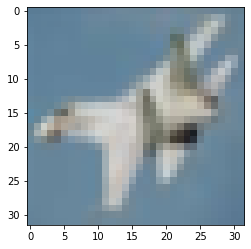

In [5]:
idx = 10
show_image(x, idx=idx)

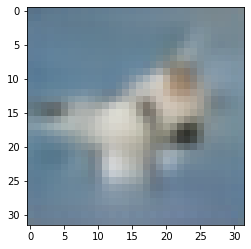

In [6]:
show_image(x_hat, idx=idx)

In [9]:
show_image(x_new, idx=idx)

NameError: name 'x_new' is not defined

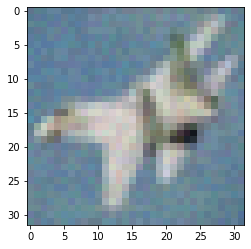

In [12]:
show_image(x_adv, idx=idx)

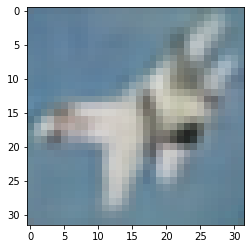

In [13]:
show_image(x_adv_new, idx=idx)

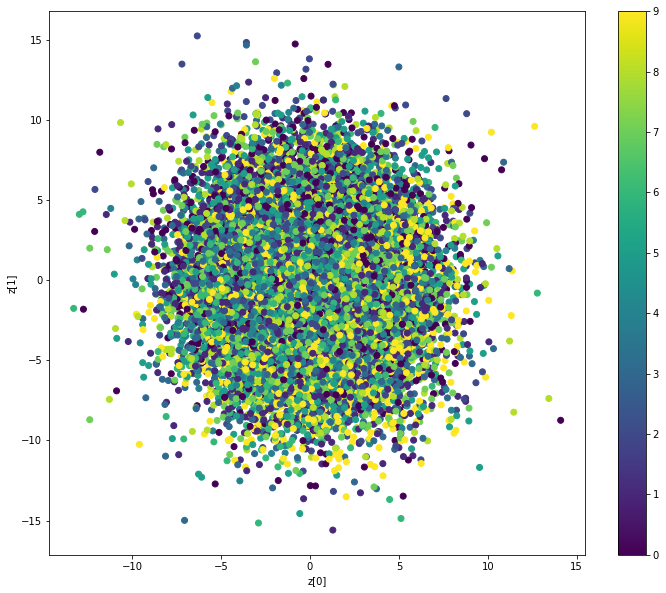

In [14]:
import matplotlib.pyplot as plt
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(VAE, train_loader):
    plt.figure(figsize=(12, 10))
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        z_mean, _,_ = VAE.encoder(data)
        plt.scatter(z_mean.cpu().detach().numpy()[:, 0], z_mean.cpu().detach().numpy()[:, 1], c=labels.cpu().detach().numpy())
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.colorbar()
    plt.show()


plot_label_clusters(vae_model, train_loader)

In [3]:
vae_model = wide_VAE(zDim=256).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
c_model = classifier().to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=0.01)
print('testing mode')
model_dir = './model-checkpoint'
test_num = 90
vae_model_path = '{}/cifar-vae-model-{}.pt'.format(model_dir, test_num)
c_model_path = '{}/cifar-c-model-{}.pt'.format(model_dir, test_num)
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))
c_model.eval()
vae_model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = Variable(data.data, requires_grad=True)
    # logit = model_pred(data, vae_model, c_model)
    # err_num += (logit.data.max(1)[1] != target.data).float().sum()
    # x_adv = pgd(vae_model, c_model, data, target, 20, 0.03, 0.003)
    # x_ = testtime_update(vae_model, x_adv ,learning_rate=0.15, num=100)
    _,_,_,x_ = vae_model(data)
    logit = c_model(x_.view(-1,160,8,8))
    break

testing mode
